# CSME2 Bonus Point Assignment II Part 3
<div style="text-align: right;font-size: 0.8em">Document Version 2.1.0, released 2022-02-09</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# FILL HERE` comments.
* Some cells create export file in the `output/` folder. _Include whole `output/` folder in your submission_.
* Make sure you restart the notebook's kernel and run everything in one go before submission
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting.

_v2.1.0 Fix imports and set default dtype to float_

In [ ]:
import torch
import torch.optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from pathlib import Path

ROOT = Path('.')
DATA = ROOT / 'data'
EXAMPLE_IMAGE = DATA / 'example_image.png'
OUTPUT = ROOT / 'output'

OUTPUT.mkdir(exist_ok=True)

# Enable reproducibility
torch.manual_seed(0)
torch.set_deterministic(True)
torch.set_default_dtype(torch.float32)

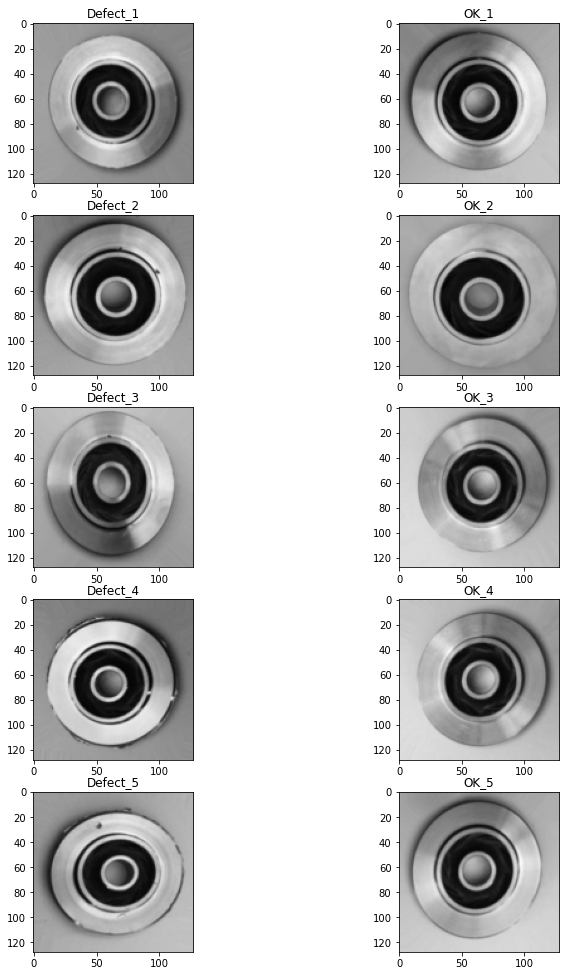

In [34]:
##### FILL HERE #####
#### Question 3.2 ###

#Import the training and test data as two torch.utils.data.Dataset objects 
tfm = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
])

train_ds = ImageFolder(DATA / 'train', transform=tfm)
val_ds = ImageFolder(DATA / 'test', transform=tfm)

train_ok_idx=5000

#Plot 5 figures of each class of training dataset
plt.figure(figsize=(12,12))
transform = transforms.ToPILImage()

for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(transform(train_ds[i][0]))
    plt.title(f'Defect_{i+1}')
    plt.subplot(5,2,2*i+2)
    plt.imshow(transform(train_ds[train_ok_idx+i][0]))
    plt.title(f'OK_{i+1}')
    
plt.subplots_adjust(top=1.2)
plt.show()

#####################

In [35]:
class SimpLeNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ##### FILL HERE #####
        #### Question 3.3 ###
        
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        
        #input size: [3, 128, 128]
        self.cnn_layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, 3, 1, 1),  #F_in: 3, F_out: 16, K=3, S=1, P=1
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2, 0)       #K=2, S=2
        )
        
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(16 * 64 * 64, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )

        #####################
        
    def forward(self, x):
        ##### FILL HERE #####
        #### Question 3.3 ###
        
        x = self.cnn_layers(x)
        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)
        x = self.fc_layers(x)
        
        return x
    
        #####################

_v2.1.0: fix typos, cast tensors to float and reshape outputs to labels_

In [36]:
def train(net, batch_size, epochs, learning_rate, qname):
    n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f'Number of trainable parameters: {n_params}')
    
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    losses = []
    
    ##### FILL HERE #####
    #### Question 3.4 ###
    # Create dataloader from train_ds
    
    dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    
    #####################
    
    with tqdm(range(epochs)) as pbar:
        for epoch in pbar:  # loop over the dataset multiple times
            running_loss = 0.0
            for i, (inputs, labels) in enumerate(dataloader):
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs.to(torch.float32))
                outputs = outputs.reshape(labels.shape)
                loss = criterion(outputs, labels.to(torch.float32))
                loss.backward()
                optimizer.step()

                # training curve
                running_loss += loss.item() * inputs.shape[0]
            
            print(f'train_loss= {running_loss:.5f}')
            
            ##### FILL HERE #####
            #### Question 3.4 ###
            # Compute Validation loss

            net.eval()                              # set model to evalutation mode
            val_loss = 0.0
              
            with torch.no_grad():                   # disable gradient calculation
                for data in valid_dataloader:
                    inputs, labels = data
                    outputs = net(inputs.to(torch.float32))   
                    outputs = outputs.reshape(labels.shape)
                    val_loss += criterion(outputs, labels.to(torch.float32)).item() * inputs.shape[0] 
                    
                print(f'valid loss= {val_loss:.5f}')
        
            #####################
            
            losses.append([running_loss, val_loss])
            pbar.set_description(f"Loss {losses[-1][0]:.02f}/{losses[-1][1]:.02f}")
    
    # Save outputs
    with open(str(OUTPUT / f'{qname}.pt'), "wb") as f:
        torch.save(net, f)
    losses = np.array(losses)
    plt.plot(np.arange(len(losses)), losses[:, 0], label="train")
    plt.plot(np.arange(len(losses)), losses[:, 1], label="validation")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(str(OUTPUT / f'{qname}.png'))

SimpLeNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=65536, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Number of trainable parameters: 1049057


  0%|          | 0/3 [00:00<?, ?it/s]

train_loss= 4721.62814
valid loss= 515.69171
train_loss= 4698.40956
valid loss= 513.73179
train_loss= 4687.36165
valid loss= 511.84345


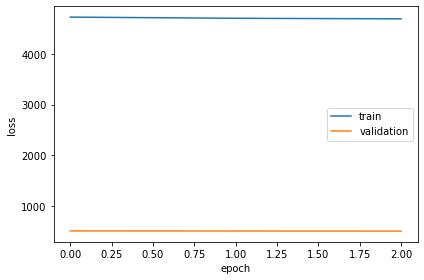

In [37]:
##### RUN HERE #####
#### Question 3.4 ###
net = SimpLeNet()
batch_size = 32
epochs = 3
learning_rate = 0.0001  #The training does not go well, mainly due to the large learning rate
qname = 'question_3-4'
print(net)
train(net, batch_size, epochs, learning_rate, qname)
#####################

In [38]:
#Print out validation result
valid_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
total_acc = 0
with torch.no_grad():                   # disable gradient calculation
    for data in valid_dataloader:
        inputs, labels = data
        
        outputs = net(inputs.to(torch.float32))                           
        acc = (torch.round(outputs[:,0])== labels.to(torch.float32)).float()
        print(f"batch acc: {acc.mean().item():.5f}")
        
        total_acc += acc.sum().item()
        
print(f"\nOverall acc: {total_acc/len(val_ds):.5f}")

batch acc: 0.40625
batch acc: 0.37500
batch acc: 0.31250
batch acc: 0.59375
batch acc: 0.34375
batch acc: 0.28125
batch acc: 0.31250
batch acc: 0.18750
batch acc: 0.25000
batch acc: 0.40625
batch acc: 0.31250
batch acc: 0.37500
batch acc: 0.37500
batch acc: 0.46875
batch acc: 0.43750
batch acc: 0.28125
batch acc: 0.34375
batch acc: 0.43750
batch acc: 0.34375
batch acc: 0.37500
batch acc: 0.40625
batch acc: 0.46875
batch acc: 0.27273

Overall acc: 0.36643


In [ ]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ##### FILL HERE #####
        #### Question 3.5 ###
        
        # 1. Add one more convolutional layer
        # 2. Add batch normalization
        self.cnn_layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, 3, 1, 1),  # input size: [3, 128, 128]
            torch.nn.BatchNorm2d(16), 
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2, 0),
            
            torch.nn.Conv2d(16, 32, 3, 1, 1), 
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(4, 4, 0)
            
        )
        
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(32*16*16, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )

        #####################

    def forward(self, x):
        ##### FILL HERE #####
        #### Question 3.5 ###
        
        x = self.cnn_layers(x)
        x = x.flatten(1)
        x = self.fc_layers(x)
        return x

        #####################
        

In [ ]:
##### RUN HERE #####
#### Question 3.5 ###
convnet = ConvNet()
batch_size = 32
epochs = 8
learning_rate = 0.0002
qname = 'question_3-5'
print(convnet)
train(convnet, batch_size, epochs, learning_rate, qname)
#####################

In [ ]:
#Print out validation result
valid_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
total_acc = 0
with torch.no_grad():                   # disable gradient calculation
    for data in valid_dataloader:
        inputs, labels = data
        
        outputs = convnet(inputs.to(torch.float32))                           
        acc = (torch.round(outputs[:,0])== labels.to(torch.float32)).float()
        print(f"batch acc: {acc.mean().item():.5f}")
        
        total_acc += acc.sum().item()
        
print(f"\nOverall acc: {total_acc/len(val_ds):.5f}")